In [68]:
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from gensim.models.fasttext import load_facebook_model
from ydata_profiling import ProfileReport
import plotly.express as px
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import re
import random
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
nltk.download('punkt') 
nltk.download('stopwords')   
nltk.download('wordnet')  
nltk.download('punkt', download_dir='/kaggle/working/nltk_data/')
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data/')
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data/')
nltk.data.path.append('/kaggle/working/nltk_data/')
import warnings
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset_path="/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df.drop(columns=["ids","date","flag"],inplace=True)

In [70]:
first_half = df.iloc[:80000]
second_half = df.iloc[80000:]

# Randomly sample 100 rows from each half
sample_first_half = first_half.sample(500, random_state=1)  # random_state for reproducibility
sample_second_half = second_half.sample(500, random_state=1)

# Concatenate the two samples into a new DataFrame
df = pd.concat([sample_first_half, sample_second_half])
df.head(10)

,target,user,text
7126,0,andrey_romanoff,@newslava welcome to the club
46624,0,rosiej,Thai place got my order wrong I want my noodl...
67020,0,devilmaysigh,tummy ache..
67356,0,hannahshu,"Hates when people, aka my sisters, eat my ice ..."
61688,0,carol_13,To doente
45869,0,smartestgames,Someone in UNITED STATES didn't like Globs htt...
42565,0,lunarlie,@tinyvamp i prefer degrassi...but since noggin...
45818,0,rich_wallace,couldn't break 6m 33s on survival - the light ...
21617,0,chrisong,"Argh, the speakers on my Macbook are screwing..."
41746,0,ScorpioRisingTX,Bad newz Wonderbred is very sick! We had to c...


In [71]:
# Plot distribution of sentiment classes
fig = px.bar(df['target'].value_counts(), title='Sentiment Distribution',
             labels={'value': 'Number of Tweets', 'index': 'Sentiment'}, 
             text_auto=True,
             template='plotly_dark')

fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

fig.show()

In [72]:
# Prepare data for pie chart
sentiment_counts = df['target'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['sentiment'] = sentiment_counts['sentiment'].map({1: 'Positive', 0: 'Negative'})

# Plot pie chart
fig = px.pie(sentiment_counts, values='count', names='sentiment', title='Sentiment Distribution',
             color='sentiment', color_discrete_map={'Positive':'#00CC96', 'Negative':'#EF553B'},
             template='plotly_dark')

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

In [73]:
df["target"]=df["target"].map({4:1,0:0})
df["target"].value_counts()

target
0    752
1    248
Name: count, dtype: int64

In [74]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https?://\S+|#\S+|@\S+|[0-9]+|\W", " ", text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)
df.head()

,target,user,text,cleaned_text
7126,0,andrey_romanoff,@newslava welcome to the club,welcome club
46624,0,rosiej,Thai place got my order wrong I want my noodl...,thai place got order wrong want noodles
67020,0,devilmaysigh,tummy ache..,tummy ache
67356,0,hannahshu,"Hates when people, aka my sisters, eat my ice ...",hates people aka sisters eat ice cream home en...
61688,0,carol_13,To doente,doente


In [75]:
vocab_size = 10000  
max_length = 100    
embedding_dim = 100 

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y = np.array(df['target'])

In [87]:
from tensorflow.keras.layers import BatchNormalization, AveragePooling1D
from tensorflow.keras.regularizers import l2

def create_cnn_model(vocab_size, embedding_dim, max_length, num_filters, kernel_size, num_conv_layers, num_dense_units, dropout_rate, num_classes, l2_rate):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(num_filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        AveragePooling1D(pool_size=2)
    ])

    for _ in range(1, num_conv_layers):
        model.add(Conv1D(num_filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)))
        model.add(BatchNormalization())
        model.add(AveragePooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_dense_units, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Adjust the optimizer with a lower learning rate
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate


In [88]:
def compile_and_train_model(model, X_train, y_train, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], epochs=10, batch_size=32, validation_split=0.2):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2)
    return history

In [89]:
def plot_model_architecture(model, filename='model.png'):
    """
    Plots the architecture of a Keras model.

    Args:
    model: Keras model instance to be plotted.
    filename: Name of the file to save the plot. The plot is also displayed using matplotlib.

    Returns:
    None
    """
    # Generate the plot
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    
    # Display the plot
    image = plt.imread(filename)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [94]:
# Define the parameters for the five models
model_params = [
    {'num_filters': 32, 'kernel_size': 3, 'num_conv_layers': 1, 'num_dense_units': 64, 'dropout_rate': 0.2, 'l2_rate': 0.01},
    {'num_filters': 64, 'kernel_size': 3, 'num_conv_layers': 2, 'num_dense_units': 128, 'dropout_rate': 0.3, 'l2_rate': 0.01},
    {'num_filters': 128, 'kernel_size': 5, 'num_conv_layers': 2, 'num_dense_units': 128, 'dropout_rate': 0.4, 'l2_rate': 0.02},
    {'num_filters': 64, 'kernel_size': 3, 'num_conv_layers': 3, 'num_dense_units': 256, 'dropout_rate': 0.5, 'l2_rate': 0.02},
    {'num_filters': 128, 'kernel_size': 3, 'num_conv_layers': 1, 'num_dense_units': 64, 'dropout_rate': 0.2, 'l2_rate': 0.01}
]


models = []
for params in model_params:
    model = create_cnn_model(
        vocab_size=10000, 
        embedding_dim=100, 
        max_length=100, 
        num_filters=params['num_filters'], 
        kernel_size=params['kernel_size'], 
        num_conv_layers=params['num_conv_layers'], 
        num_dense_units=params['num_dense_units'], 
        dropout_rate=params['dropout_rate'], 
        num_classes=2,
        l2_rate=params['l2_rate'] 
    )
    models.append(model)



In [95]:
def train_models(models, X_train, y_train):
    histories = []
    for model in models:
        history = compile_and_train_model(
            model, 
            X_train, 
            y_train, 
            epochs=5, 
            batch_size=64
        )
        histories.append(history)
    return histories
histories = train_models(models, padded_sequences, y)


Epoch 1/5
13/13 - 4s - 274ms/step - accuracy: 0.7050 - loss: 1.4864 - val_accuracy: 0.5100 - val_loss: 1.5484
Epoch 2/5
13/13 - 1s - 70ms/step - accuracy: 0.8138 - loss: 1.2208 - val_accuracy: 0.5100 - val_loss: 1.4659
Epoch 3/5
13/13 - 1s - 48ms/step - accuracy: 0.8637 - loss: 1.0209 - val_accuracy: 0.5100 - val_loss: 1.3884
Epoch 4/5
13/13 - 0s - 30ms/step - accuracy: 0.9350 - loss: 0.8444 - val_accuracy: 0.5200 - val_loss: 1.3169
Epoch 5/5
13/13 - 1s - 46ms/step - accuracy: 0.9750 - loss: 0.6945 - val_accuracy: 0.5350 - val_loss: 1.2520
Epoch 1/5
13/13 - 5s - 350ms/step - accuracy: 0.7000 - loss: 3.3581 - val_accuracy: 0.5100 - val_loss: 2.8955
Epoch 2/5
13/13 - 1s - 41ms/step - accuracy: 0.7825 - loss: 2.7888 - val_accuracy: 0.5100 - val_loss: 2.8304
Epoch 3/5
13/13 - 1s - 42ms/step - accuracy: 0.8175 - loss: 2.5787 - val_accuracy: 0.5100 - val_loss: 2.7639
Epoch 4/5
13/13 - 1s - 42ms/step - accuracy: 0.8575 - loss: 2.3830 - val_accuracy: 0.5100 - val_loss: 2.6960
Epoch 5/5
13/13 -

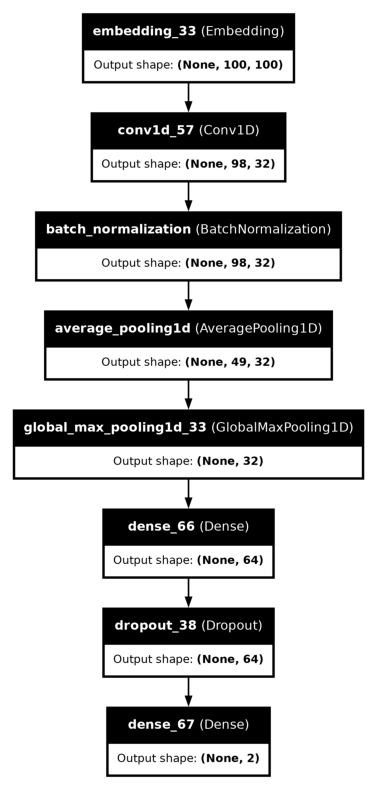

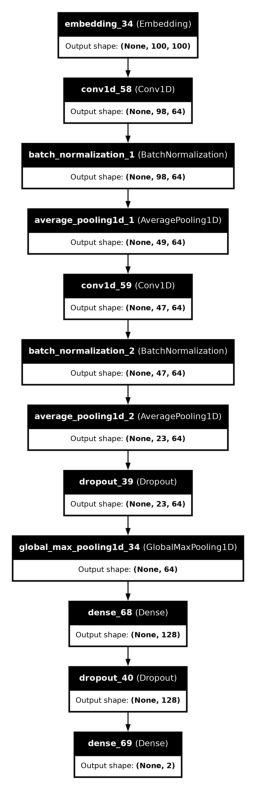

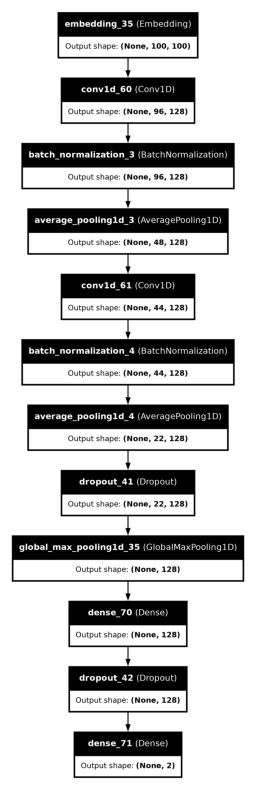

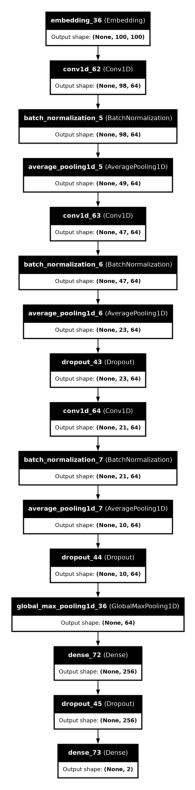

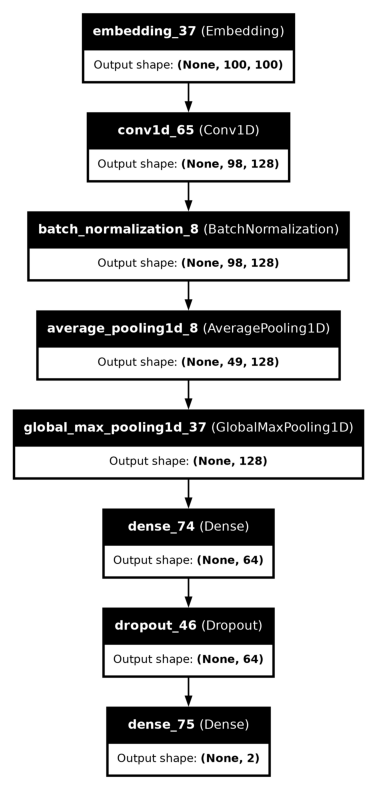

In [108]:
model_images = []
for i, model in enumerate(models):
    plot_model_architecture(model, filename=f'model_{i+1}.png')
    image = Image.open(f'model_{i+1}.png')
    model_images.append(image)
    image = image.resize((800, 600))  # Adjust the size as needed
    model_images.append(image)


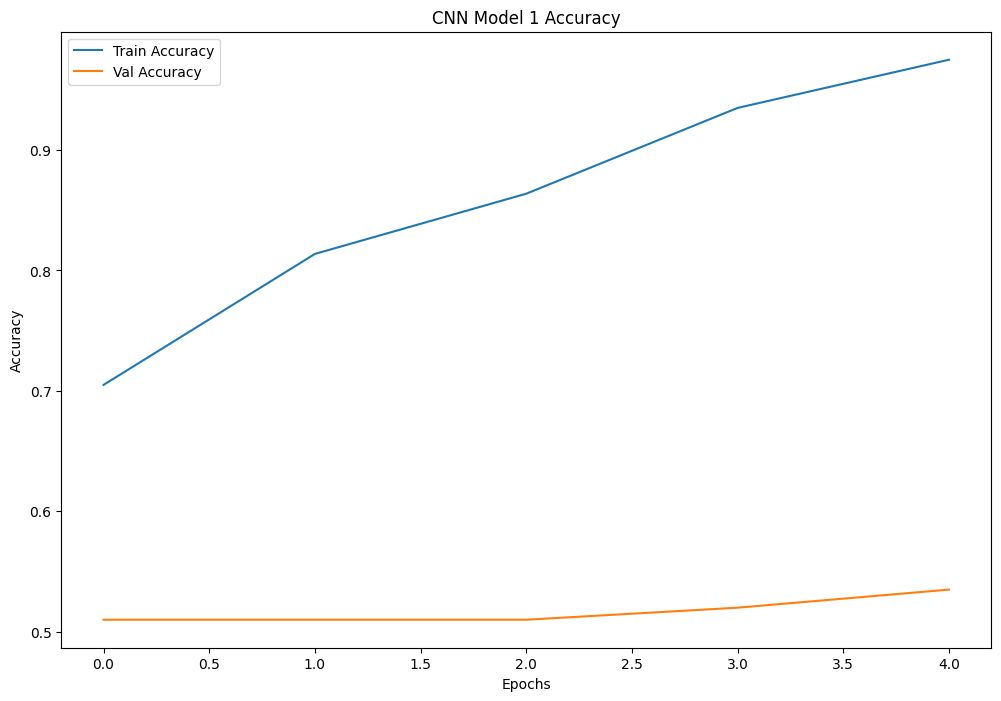

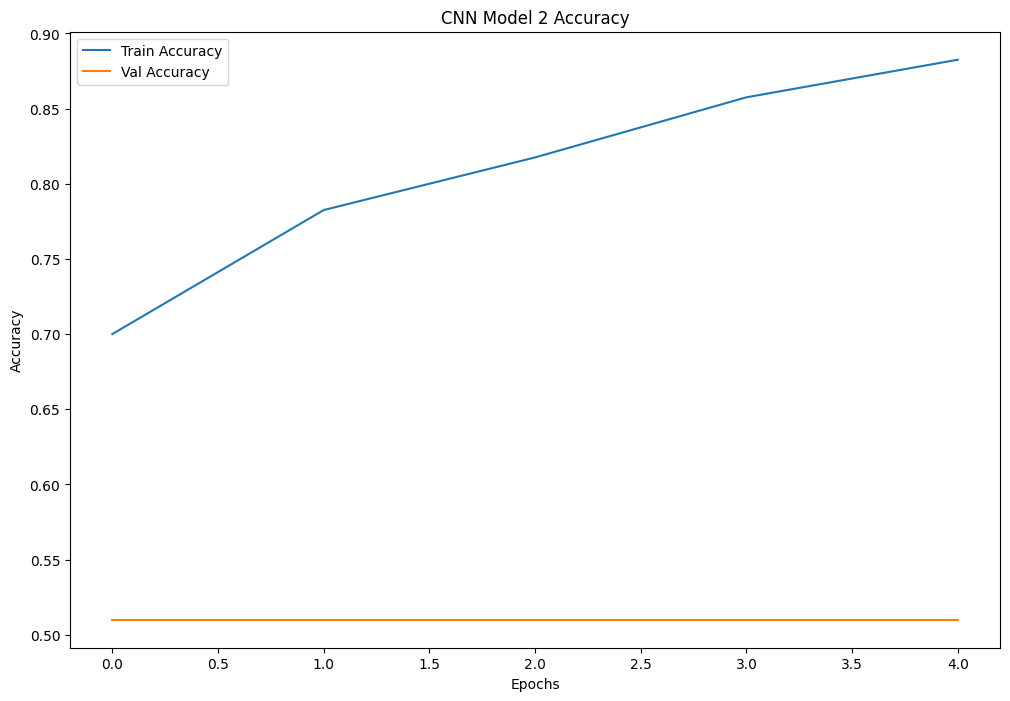

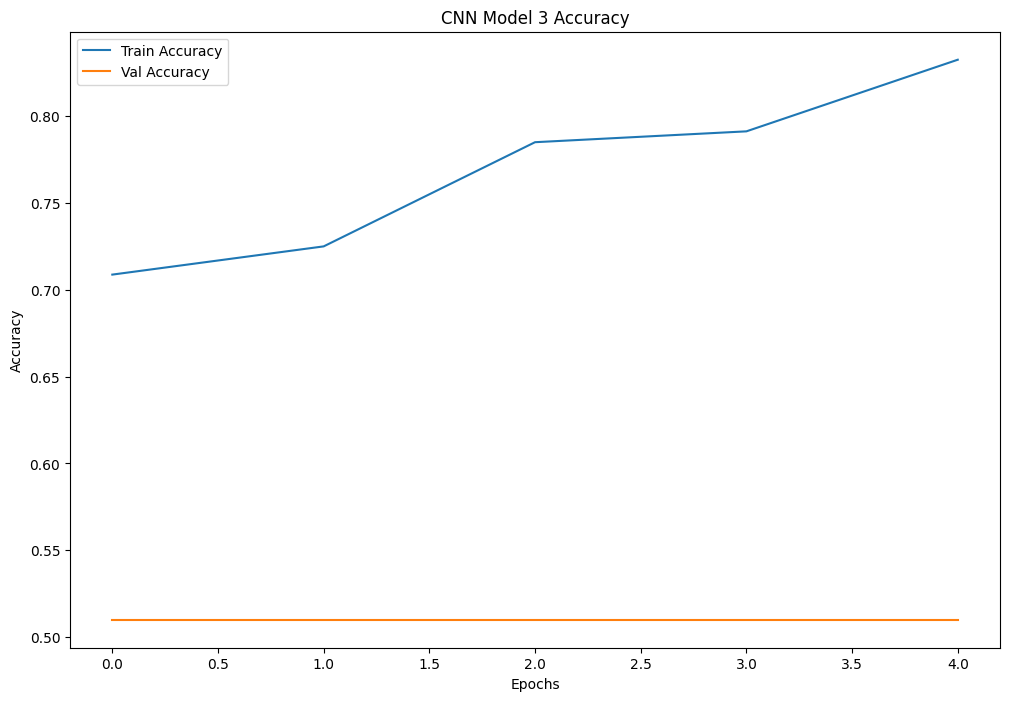

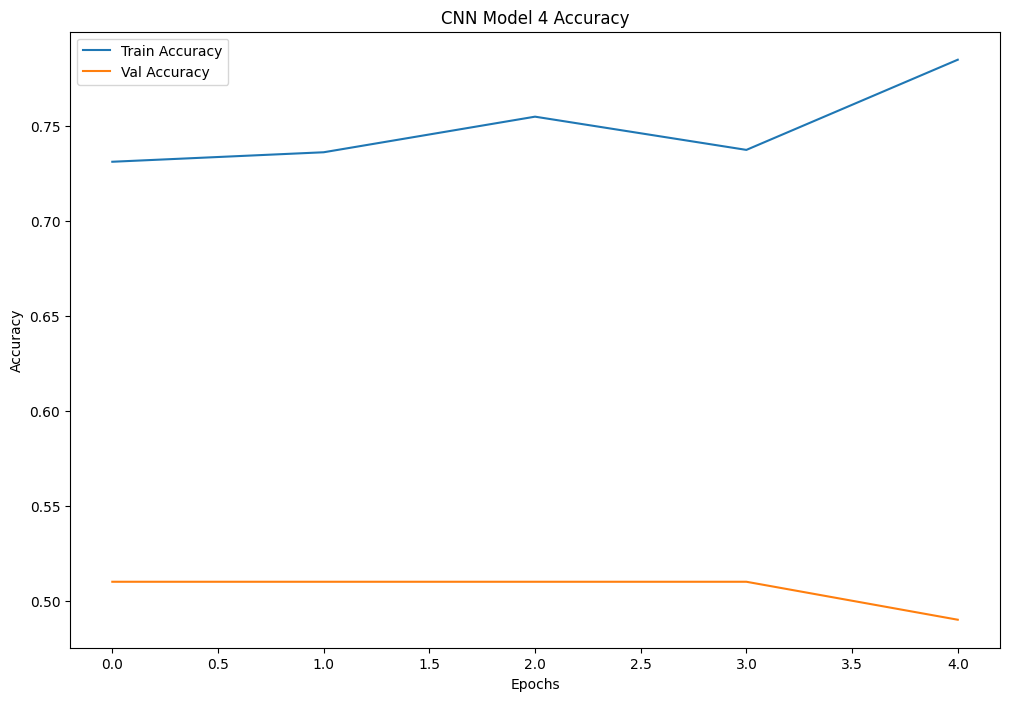

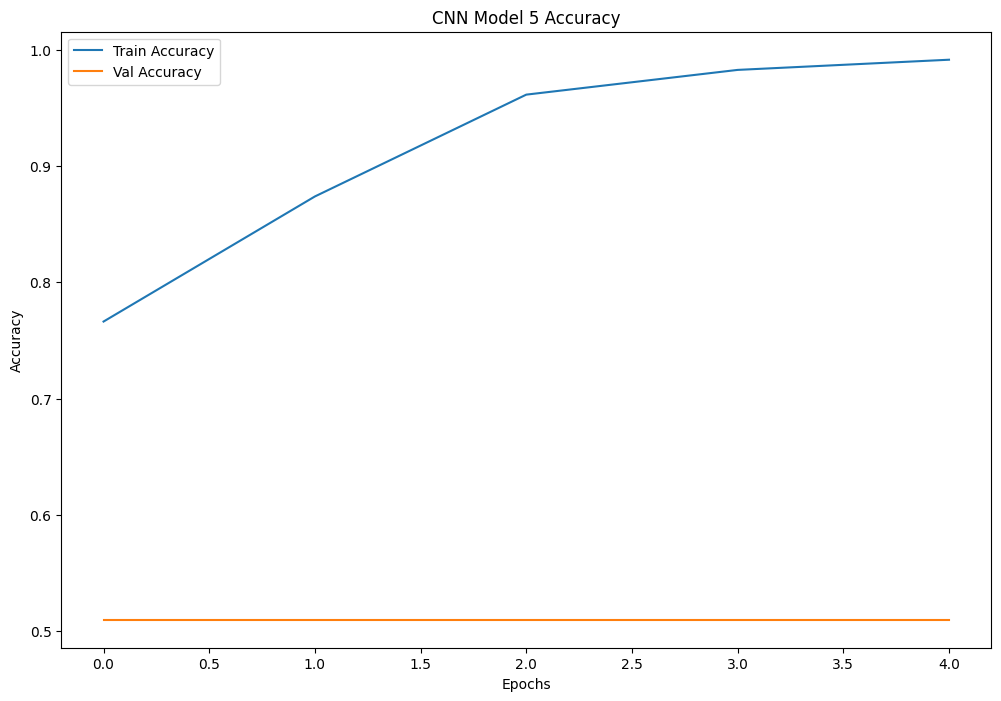

In [109]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 8)) 
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    
    plt.title(f'CNN Model {i+1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [110]:
def save_results_to_pdf(histories, model_images, filename):

    with PdfPages(filename) as pdf:
        for i, history in enumerate(histories):
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f'Model {i + 1} Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            pdf.savefig()
            plt.close()

        for i, image in enumerate(model_images):
            plt.figure()
            plt.imshow(image)
            plt.axis('off')
            pdf.savefig()
            plt.close()

        plt.figure(figsize=(10, 6))
        plt.axis('off')
        plt.text(0.5, 0.5, 'Summary of Model Performances', ha='center')
        pdf.savefig()
        plt.close()

save_results_to_pdf(histories, model_images, 'model_results.pdf')
